## Initialize values

In [2]:
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

sns.set_theme(palette="colorblind", style="ticks")

model_params = {\
    "thickness" : {"thick": 0.0013, "thin": 0.0002},
    "E" : {"70_S":2508*3,"70_H":16082*3,"80_S":9344*3,"80_H":17507*3},
    "E_max" : {"70_S":(2508+21)*3,"70_H":(16082+167)*3,"80_S":(9344+50)*3,"80_H":(17507+200)*3},
    "E_min" : {"70_S":(2508-21)*3,"70_H":(16082-167)*3,"80_S":(9344-50)*3,"80_H":(17507-200)*3},
    "upsilon" : (0.059+0.016)/2, # from Park et al, Ups_s = Ups_SV + Ups_SL / 2
    "gamma" : 0.072, # from https://en.wikipedia.org/wiki/Surface_tension
}

source_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\raw_data")

eval_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\eval\public")
if not eval_dir.exists(): eval_dir.mkdir()

order = ["80_S_thin", "80_S_thick", "80_H_thin", "80_H_thick"]    

plot_out_dir = Path(r"D:\Publications\Paper4-Wetting-ridge\plots\public")


## Raw Data Processing

In [91]:
import numpy as np
from pathlib import Path
import pickle
from ridge_extractor import extract_ridge_from_image

def extract_ridge(file):
    ridge, image, circ_params, _, r2, pixelscale,stdev,sterr = \
            extract_ridge_from_image(file, robust=True, threshold=0.7, use_kmeans=False, butterworth_cutoff=0.01, gamma_correction=3)
    x,y = ridge
    radius = x[np.argmax(y[10:])+10]
    return circ_params,radius,r2,image,pixelscale,ridge,stdev,sterr

sources = source_dir.rglob("*.tif")
for file in sources:
    print(f"{file.stem}", end="")
    try:
        result = extract_ridge(file)
    except Exception as e:
        print(f" - Error: {e}")
        continue
    print(f" - Circle: {result[0]} Radius: {result[1]:.6f} R2: {result[2]:.4f}")
    target_path = file.relative_to(source_dir)
    target_file = (eval_dir / target_path).with_suffix(".pkl")
    target_file.parent.mkdir(parents=True, exist_ok=True)
    iron_content, shear_mod, drop_vol, thickness,_,magntype, *_ = Path(file).stem.split("_")
    pickle.dump(result + (iron_content,shear_mod,drop_vol,thickness,magntype), open(target_file, "wb"))



80_H_1_thick_magn_120mT_f.ome - Circle: (1374, 1412, 863) Radius: 0.000549 R2: 0.9747
80_H_1_thin_magn_120mT_f.ome - Circle: (1407, 1457, 913) Radius: 0.000579 R2: 0.9989
80_S_1_thick_magn_120mT_f.ome - Circle: (1447, 1436, 1021) Radius: 0.000647 R2: 0.9574
80_S_1_thin_magn_120mT_f.ome - Circle: (1480, 1440, 906) Radius: 0.000573 R2: 0.9993
80_H_1_thick_magn_270mT_f.ome - Circle: (2270, 1480, 1162) Radius: 0.000734 R2: 0.9016
80_H_1_thick_magn_quer_f.ome - Circle: (1432, 1372, 1085) Radius: 0.000700 R2: 0.9981
80_H_1_thick_mag_220mT_f.ome - Circle: (1530, 1396, 1051) Radius: 0.000680 R2: 0.9872
80_H_1_thin_magn_270mT_f.ome - Circle: (1446, 1449, 1063) Radius: 0.000690 R2: 0.9337
80_H_1_thin_magn_quer_f.ome - Circle: (1410, 1443, 1043) Radius: 0.000655 R2: 0.9167
80_H_1_thin_mag_220mT_f.ome - Circle: (1474, 1464, 1162) Radius: 0.000732 R2: 0.9120
80_S_1_thick_magn_270mT_f.ome - Circle: (1437, 1420, 925) Radius: 0.000584 R2: 0.9997
80_S_1_thick_magn_quer_f.ome - Circle: (1407, 1447, 892)

## Data Ingestion & Postprocessing

In [29]:
from ridge_models import style_exact
from scipy.signal import savgol_filter
df_list = list()

for file in eval_dir.rglob("*.pkl"):
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,ridge,stdev,sterr,iron_content,matrix,drop_vol,thickness,magntype = pickle.load(f)
    x,y = ridge
    y = y*1e6

    
    fit_y_th = 1e6*style_exact(x, model_params["gamma"], radius, model_params["gamma"], model_params["E"][f"{iron_content}_{matrix}"], model_params["thickness"][f"{thickness}"])
    # 0 degree savgol filter equals moving average, yes this is the easiest way to do this
    x= x*1e6
    radius = radius*1e6
    stdev = stdev*1e6
    sterr = sterr*1e6
    norm_x = x / radius

    y_smooth = savgol_filter(y, 25, 0)
    stdev_smooth = savgol_filter(stdev, 25, 0)
    sterr_smooth = savgol_filter(sterr, 25, 0)

    df = pd.DataFrame({ "x":[x], "norm_x":[norm_x], "y":[y], "y_err": [sterr], 
                        "y_smooth":[y_smooth], "y_err_smooth":[sterr_smooth], "fit_y_th":[fit_y_th],
                        "iron_content":iron_content, "matrix":matrix, "drop_vol":drop_vol, "thickness":thickness, "magntype":magntype, "R2":r2, "radius":radius})
    
    df_list.append(df)
    print(f"{file.stem} - R2: {r2:.3f} - r {radius}")

master_data = pd.concat(df_list, ignore_index=True)
master_data["id"] = master_data["iron_content"] + "_" + master_data["matrix"] + "_" + master_data["thickness"]
master_data["magntype_disp"] = master_data["magntype"].replace({"quer":"$\\rightarrow$120","120mT":"$\\uparrow$120","220mT":"$\\uparrow$220","270mT":"$\\uparrow$270"})
master_data["thickness_mm"] = master_data["thickness"].replace({"thick":"1.2 mm","thin":"0.2 mm"})
master_data["shear_mod"] = master_data["matrix"].replace({"H":"17.5 kPa","S":"9.3 kPa"})
master_data["peak_height"] = master_data["y"].apply(lambda x: max(x))
master_data["peak_height_err"] = master_data["y_err"].apply(lambda x: max(x))


data_120mT = master_data.copy().groupby("magntype").get_group("120mT")
data_120mT = data_120mT.sort_values("id", key=lambda x: x.map(order.index))

80_H_1_thick_magn_120mT_f.ome - R2: 0.975 - r 548.9999894052744
80_H_1_thin_magn_120mT_f.ome - R2: 0.999 - r 578.9999850094318
80_S_1_thick_magn_120mT_f.ome - R2: 0.957 - r 646.9999789260328
80_S_1_thin_magn_120mT_f.ome - R2: 0.999 - r 572.9999975301325
80_H_1_thick_magn_270mT_f.ome - R2: 0.902 - r 734.0000011026859
80_H_1_thick_magn_quer_f.ome - R2: 0.998 - r 699.999975040555
80_H_1_thick_mag_220mT_f.ome - R2: 0.987 - r 679.9999973736703
80_H_1_thin_magn_270mT_f.ome - R2: 0.934 - r 690.0000153109431
80_H_1_thin_magn_quer_f.ome - R2: 0.917 - r 654.9999816343188
80_H_1_thin_mag_220mT_f.ome - R2: 0.912 - r 731.9999858736992
80_S_1_thick_magn_270mT_f.ome - R2: 1.000 - r 584.0000230818987
80_S_1_thick_magn_quer_f.ome - R2: 0.988 - r 554.9999768845737
80_S_1_thick_mag_220mT_f.ome - R2: 1.000 - r 598.000013269484
80_S_1_thin_magn_270mT_f.ome - R2: 1.000 - r 622.0000213943422
80_S_1_thin_magn_quer_f.ome - R2: 0.961 - r 623.999978415668
80_S_1_thin_mag_220mT_f.ome - R2: 0.999 - r 629.000016488

## 2D Experimental plots

### 2D ridge

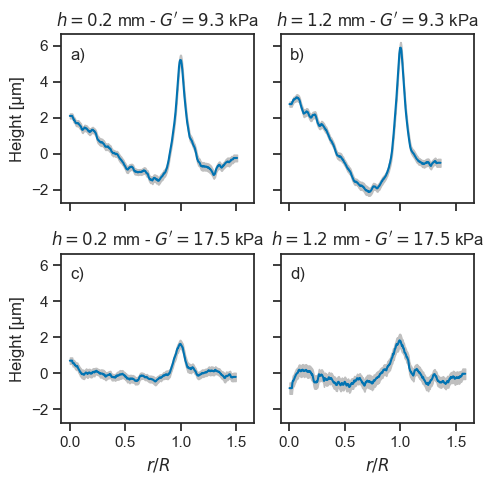

In [103]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.2$ mm - $G'=9.3$ kPa", "80_S_thick":"$h=1.2$ mm - $G'=9.3$ kPa", "80_H_thin":"$h=0.2$ mm - $G'=17.5$ kPa", "80_H_thick":"$h=1.2$ mm - $G'=17.5$ kPa"}

grp = data_120mT.groupby("id")
for i, key in enumerate(order):
    ax = axes[i//2, i%2]
    df = grp.get_group(key)
    norm_x = df["norm_x"].iloc[0]
    y_smooth = df["y_smooth"].iloc[0]
    y_err = df["y_err_smooth"].iloc[0]
    ax.fill_between(norm_x, y_smooth-y_err, y_smooth+y_err, color=(0.75,0.75,0.75,1))
    sns.lineplot(x=norm_x, y=y_smooth, ax=ax)
    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height [µm]")

    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
plt.tight_layout()
fig.savefig(plot_out_dir / "ridge_fit.pdf", bbox_inches="tight")

### 2D ridge comparison to model calculated with measured values

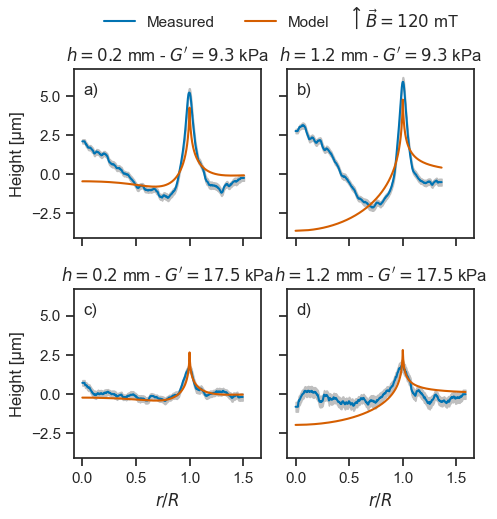

In [75]:
fig,axes = plt.subplots(2,2, figsize=(5,5), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"$h=0.2$ mm - $G'=9.3$ kPa", "80_S_thick":"$h=1.2$ mm - $G'=9.3$ kPa", "80_H_thin":"$h=0.2$ mm - $G'=17.5$ kPa", "80_H_thick":"$h=1.2$ mm - $G'=17.5$ kPa"}
# title_dict = {"80_S_thin":"0.2 mm - 9.3 kPa", "80_S_thick":"1.2 mm - 9.3 kPa", "80_H_thin":"0.2 mm - 17.5 kPa", "80_H_thick":"1.2 mm - 17.5 kPa"}
real_x = np.linspace(0,1.5e-3,250)
grp = data_120mT.groupby("id")
for i, key in enumerate(order):
    ax = axes[i//2, i%2]
    df = grp.get_group(key)
    norm_x = df["norm_x"].iloc[0]
    y_smooth = df["y_smooth"].iloc[0]
    y_err = df["y_err_smooth"].iloc[0]
    fit_y_th = df["fit_y_th"].iloc[0]
    ax.fill_between(norm_x, y_smooth-y_err, y_smooth+y_err, color=(0.75,0.75,0.75,1))
    sns.lineplot(x=norm_x, y=y_smooth, ax=ax, label="Measured")
    colorpalette = sns.color_palette()
    sns.lineplot(x=norm_x,y=fit_y_th, ax=ax, color=colorpalette[3], label="Model")

    ax.set_title(title_dict[key])
    ax.set_xlabel("$r/R$")
    ax.set_ylabel("Height [µm]")
    ax.text(0.05, 0.85, subplot_labels[i], transform=ax.transAxes)
    ax.get_legend().remove()

handles, labels = axes.flatten()[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.45, 1.05), ncol=2, frameon=False)

# plt.sca(axes.flatten()[-1])
plt.tight_layout()
plt.annotate("$\\longrightarrow$", xy=(0.7,1.0), ha="left", rotation=90, xycoords="figure fraction", va="center")
plt.annotate("$\\vec{B}=120$ mT ", xy=(0.73,1.0), ha="left", xycoords="figure fraction", va ="center")
# plt.tight_layout()
fig.savefig(plot_out_dir / "ridge_fit_sc_real.pdf", bbox_inches="tight")
# fig.savefig(plot_out_dir / "ridge_fit_sc_real.png", bbox_inches="tight")

### 2D ridge compare magn field

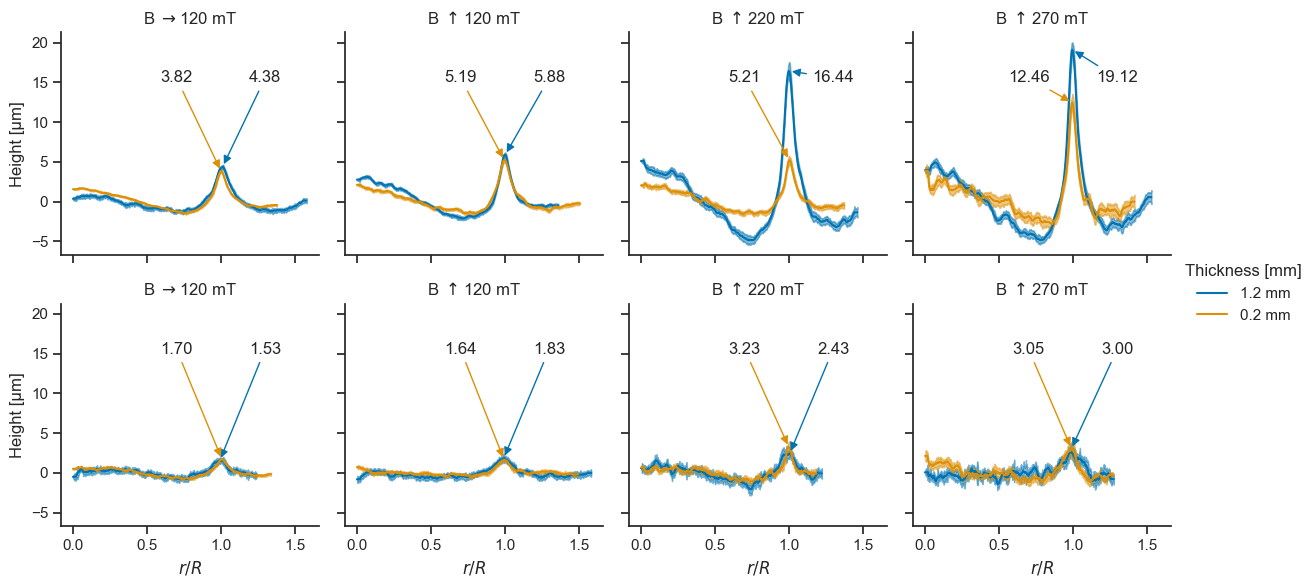

In [95]:
def plot_nested_data(*args,**kwargs):
    color = kwargs.pop("color")
    data = kwargs.pop("data")
    x = np.asarray(data[args[0]].values[0])
    y = np.asarray(data[args[1]].values[0])
    y_err = np.asarray(data["y_err"].values[0])
    #
    plt.fill_between(x, y-y_err, y+y_err, alpha=0.5, color=color)
    plt.plot(x,y, color=color, **kwargs)
    max_idx = np.argmax(y)
    max_y = y[max_idx]
    if "label" in kwargs:
        if "0.2" in kwargs["label"]:
            plt.annotate(f"{max_y:0.2f}", (x[max_idx], max_y), textcoords="data", xytext=(0.7,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
        else:
            plt.annotate(f"{max_y:0.2f}", (x[max_idx], max_y), textcoords="data", xytext=(1.3,15), ha='center', arrowprops=dict(arrowstyle='-|>', color=color))
    plt.legend()

grid = sns.FacetGrid(data=master_data, col="magntype_disp", row="shear_mod", hue="thickness_mm", sharex=True, sharey=True, aspect=1, height=3, legend_out=True, 
                     col_order= ["$\\rightarrow$120","$\\uparrow$120","$\\uparrow$220","$\\uparrow$270"],
                     row_order=["9.3 kPa","17.5 kPa"])

grid.set_titles(template="B {col_name} mT")
grid.map_dataframe(plot_nested_data, "norm_x", "y_smooth")
for info,ax in grid.axes_dict.items():
    if info[1] != "$\\rightarrow$120 mT": continue
    plt.sca(ax)
    plt.annotate(info[0], (-0.8, .5), xycoords="axes fraction", ha='center', va='center', fontsize=12, rotation=90)


# grid.figure.tight_layout()
grid.add_legend(title="Thickness [mm]" )
grid.set_xlabels("$r/R$")
grid.set_ylabels("Height [µm]")
grid.savefig(plot_out_dir / "ridge_profiles_comp.pdf")

### Peaks Comparison

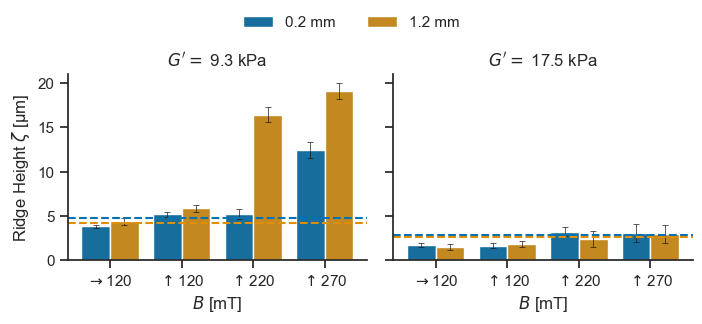

In [105]:
def catplot_error(err, hue=None, col=None, row=None, data:pd.DataFrame =None, **kwargs) -> sns.FacetGrid:
    if err is None: raise ValueError("err not given")

    bar_lbl_fmt = kwargs.pop('bar_lbl_fmt',"%.0f")
    facet: sns.FacetGrid = sns.catplot(data=data, col=col, row=row, hue=hue, **kwargs)
    ax_arr = facet.axes
    _error_df = data.copy(True)

    _error_df.sort_values(hue,inplace=True)
    _error_grps = _error_df.groupby(col)

    for ax, grp  in zip(ax_arr.ravel(order='F'), _error_grps.groups):
        # error bar
        x_coords = [p.get_x() + 0.5*p.get_width() for p in ax.patches]
        y_coords = [p.get_height() for p in ax.patches]

        err_val = _error_grps.get_group(grp)[err]

        plt.sca(ax)
        plt.axhline
        plt.errorbar(x=x_coords[:len(err_val)], y=y_coords[:len(err_val)], yerr=err_val, fmt="none", c="k", capsize=2, elinewidth=.5, capthick=.5)


    return facet

ordered_data = master_data.sort_values(by=["magntype_disp"], key=lambda x: x.map({"$\\rightarrow$120":0,"$\\uparrow$120":1,"$\\uparrow$220":2,"$\\uparrow$270":3}))

ordered_data["peak_height_roll"] = ordered_data["y"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())
ordered_data["peak_height_roll_err"] = ordered_data["y_err"].apply(lambda x: pd.Series(np.asarray(x)).rolling(25, center=True).mean().max())



grid = catplot_error(data=ordered_data, x="magntype_disp", y="peak_height_roll", err="peak_height_roll_err", hue="thickness_mm", col="shear_mod", kind="bar", 
                     sharey=True, aspect=1, height=3, legend_out=True, col_order=["9.3 kPa","17.5 kPa"], hue_order=["0.2 mm","1.2 mm"])
# iterate through axes

fit_y_data = master_data.groupby("magntype").get_group("120mT").copy()
fit_y_data["fit_max"] = fit_y_data["fit_y_th"].apply(lambda x: max(x))

fit_max = dict()
for row in fit_y_data.itertuples():
    fit_max[f"{row.shear_mod}_{row.thickness}"] = row.fit_max

for ax in grid.axes.ravel():
    if  "9.3 kPa" in ax.get_title():
        softness = "S"
    else:
        softness = "H"

    palette = sns.color_palette()
    shear = ax.get_title().split('=')[-1].strip()
    ax.axhline(fit_max[f"{shear}_thick"], color=palette[0], linestyle="--")
    ax.axhline(fit_max[f"{shear}_thin"], color=palette[1], linestyle="--")

sns.move_legend(grid, "upper center", bbox_to_anchor=(0.5, 1.1), ncol=2, title=None)
# grid.legend.set_title("Thickness [mm]")
grid.set_titles(col_template="$G'=$ {col_name}", row_template="")
grid.set_xlabels("$B$ [mT]")
grid.set_ylabels("Ridge Height $\\zeta$ [µm]")
plt.tight_layout()
grid.savefig(plot_out_dir / "peak_compare_magn.pdf")

## 3D Plots

### 3D Plot 2x2 grid measured

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots
subplot_labels = ["a)","b)","c)","d)"]
title_dict = {"80_S_thin":"h = 0.2 mm - G = 9.3 kPa", "80_S_thick":"h = 1.2 mm - G = 9.3 kPa", 
              "80_H_thin":"h = 0.2 mm - G = 17.5 kPa", "80_H_thick":"h = 1.2 mm - G = 17.5 kPa"}
images = {}
rescale_factor = 8
for file in eval_dir.glob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_= pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
    x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs

    # x_grid,y_grid = np.meshgrid(x, y)
    # radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    images[f"{iron_content}_{shear_mod}_{thickness}"] = dict(z=image, x=x*1000, y=y*1000)


fig = make_subplots(
    rows=2, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0, 
    specs=[[{'type': 'surface'}, {'type': 'surface'}],
            [{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=[title_dict[key] for key in order]
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thin"]),
                row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"]),
                row=1, col=2)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thin"]),
                row=2, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thick"]),
                row=2, col=2)

fig.update_layout(#title="80_S", autosize=True,
                    width=650, height=600,
                    margin=dict(l=0, r=0, b=0, t=0),
                    font_size=14,
                    font_color="black",
                    font_family="sans-serif",
)

fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height [mm]", 
                        colorbar_title_side="top", cmax=0.01, cmin=-0.01)



fig["layout"]["annotations"][0]["y"]=0.87
fig["layout"]["annotations"][1]["y"]=0.87
fig["layout"]["annotations"][2]["y"]=0.48
fig["layout"]["annotations"][3]["y"]=0.48
#location of the annotations
anno_x = [0.05, 0.55]
anno_y = [0.85, 0.45]
annotations = list()
for i, label in enumerate(subplot_labels):
    fig.add_annotation(text=label, x=anno_x[i % 2], y=anno_y[i // 2], xref='paper', yref='paper', showarrow=False, font=dict(size=18))


camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1.2, y=-1.2, z=1.2)
)
camera2 = dict(
    up=dict(x=0, y=0, z=.5),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-1.2, y=-1.2, z=1.2)
)

# fig.update_layout(scene_camera=camera)
fig.layout.scene1.camera = camera
fig.layout.scene2.camera = camera
fig.layout.scene3.camera = camera2
fig.layout.scene4.camera = camera2

scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
            xaxis_title="x [mm]",
            yaxis_title="y [mm]",
            # zaxis_title="Height [mm]",
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, title_text=""))

fig.update_layout(scene1=scene, scene2=scene, scene3=scene, scene4=scene)

fig.show()
fig.write_html(str(plot_out_dir / "3D_plot.html"))
fig.write_image(str(plot_out_dir / "3D_plot.pdf"),scale=4)

### 3D Plots 2x4 grid, compare measured with model

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from ridge_models import style_exact
# subplot_labels = ["a)","b)","c)","d)"]
# title_dict = {"80_S_thin":"$h=0.2 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", "80_S_thick":"$h=1 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", 
#               "80_H_thin":"$h=0.2 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$", "80_H_thick":"$h=1 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$"}
images = {}

def _fit_calc(radial_coord, radius):
    img_calc = np.zeros_like(radial_coord)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_coord[i,:], model_params["gamma"], radius, model_params["gamma"], model_params["E"][f"{iron_content}_{shear_mod}"], model_params["thickness"][f"{thickness}"])
    return img_calc

rescale_factor = 8
for file in eval_dir.glob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_ = pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
    x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs

    x_grid,y_grid = np.meshgrid(x, y)
    radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    img_calc = _fit_calc(radial_coord,radius)*1000
    img_calc = gaussian(img_calc, sigma=1)

    # image[:, image.shape[0]//2:] = img_calc[:, image.shape[0]//2:]
    images[f"{iron_content}_{shear_mod}_{thickness}"] = (dict(z=image, x=x*1000, y=y*1000), dict(z=img_calc, x=x*1000, y=y*1000))


fig = make_subplots(
    rows=2, cols=4, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0,
    specs=[[{'type': 'surface'}, {'type': 'surface'},{'type': 'surface'}, {'type': 'surface'}],
            [{'type': 'surface'}, {'type': 'surface'},{'type': 'surface'}, {'type': 'surface'}]],
    # subplot_titles=[title_dict[key] for key in order]
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thin"][0]),
                row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][0]),
                row=1, col=2)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thin"][0]),
                row=1, col=3)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thick"][0]),
                row=1, col=4)

fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thin"][1]),
                row=2, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][1]),
                row=2, col=2)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thin"][1]),
                row=2, col=3)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_H_thick"][1]),
                row=2, col=4)

fig.update_layout(#title="80_S", autosize=True,
                    width=1200, height=600,
                    margin=dict(l=10, r=10, b=0, t=0),
                    font_size=14,
                    font_color="black",
                    font_family="sans-serif",
  
                    
)

fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height [mm]", 
                        colorbar_title_side="top", cmax=0.008, cmin=-0.008)


distance = 1.2
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-distance, y=-distance, z=distance)
)
camera2 = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-distance, y=-distance, z=distance)
)

scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=.2),
            xaxis_title="x [mm]",
            yaxis_title="y [mm]",
            # zaxis_title="Height [mm]",
            camera=camera,
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, range=[-0.01,0.01]))
scene2=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=.2),
            xaxis_title="x [mm]",
            yaxis_title="y [mm]",
            # zaxis_title="Height [mm]",
            camera=camera2,
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, range=[-0.01,0.01]))

fig.update_layout(scene1=scene, scene2=scene, scene3=scene, scene4=scene, scene5=scene2, scene6=scene2, scene7=scene2, scene8=scene2)

fig.show()
fig.write_html(str(plot_out_dir / "3D_compare_th.html"))
fig.write_image(str(plot_out_dir / "3D_compare_th.pdf"),scale=4)
# fig.write_image(str(plot_out_dir / "3D_compare_th.png"),scale=4)

### 3D plot compare single sample to model

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from ridge_models import style_exact
# subplot_labels = ["a)","b)","c)","d)"]
# title_dict = {"80_S_thin":"$h=0.2 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", "80_S_thick":"$h=1 \\text{\\,mm - }G'=9.3\\text{\\,kPa}$", 
#               "80_H_thin":"$h=0.2 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$", "80_H_thick":"$h=1 \\text{\\,mm - }G'=17.5\\text{\\,kPa}$"}
images = {}

def _fit_calc(radial_coord, radius):
    img_calc = np.zeros_like(radial_coord)

    for i in np.ndindex(img_calc.shape[0]):
        img_calc[i,:] = style_exact(radial_coord[i,:], model_params["gamma"], radius, model_params["gamma"], model_params["E"][f"{iron_content}_{shear_mod}"], model_params["thickness"][f"{thickness}"])
    return img_calc

rescale_factor = 8
for file in eval_dir.glob("80_S_1_thick_*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_ = pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = (np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs
    x = (np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs

    x_grid,y_grid = np.meshgrid(x, y)
    radial_coord = np.sqrt((x_grid)**2 + (y_grid)**2).astype(np.float32)
    img_calc = _fit_calc(radial_coord,radius)*1000
    img_calc = gaussian(img_calc, sigma=1)

    # image[:, image.shape[0]//2:] = img_calc[:, image.shape[0]//2:]
    images[f"{iron_content}_{shear_mod}_{thickness}"] = (dict(z=image, x=x*1000, y=y*1000), dict(z=img_calc, x=x*1000, y=y*1000))


fig = make_subplots(
    rows=1, cols=2, shared_xaxes=True, shared_yaxes=True, vertical_spacing=0, horizontal_spacing=0,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    # subplot_titles=[title_dict[key] for key in order]
)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][0]),
                row=1, col=1)
fig.add_trace(go.Surface(colorscale="icefire", showscale=False, coloraxis="coloraxis", **images["80_S_thick"][1]),
                row=1, col=2)

fig.update_layout(#title="80_S", autosize=True,
                    width=600, height=300,
                    margin=dict(l=10, r=10, b=0, t=0),
                    font_size=14,
                    font_color="black",
                    font_family="sans-serif",
  
                    
)

fig.update_coloraxes(colorscale='icefire', colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                        colorbar_title="Height [mm]", 
                        colorbar_title_side="top", cmax=0.008, cmin=-0.008)


distance = 1.2
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=-.5),
    eye=dict(x=-distance, y=-distance, z=distance)
)


scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=.2),
            xaxis_title="x [mm]",
            yaxis_title="y [mm]",
            # zaxis_title="Height [mm]",
            camera=camera,
            zaxis = dict(nticks=2,  showticklabels=False, showaxeslabels=False, range=[-0.01,0.01]))


fig.update_layout(scene1=scene, scene2=scene)

fig.show()
fig.write_html(str(plot_out_dir / "3D_compare_th_single.html"))
fig.write_image(str(plot_out_dir / "3D_compare_th_single.pdf"),scale=4)

### Individual Renders

In [ ]:
from skimage.filters import gaussian
from skimage.transform import rescale
from plotly import graph_objects as go

images = {}
rescale_factor = 8
for file in eval_dir.rglob("*.pkl"):
    # if not "80_S" in str(file):
    #     continue
    iron_content, shear_mod, drop_vol, thickness, _, magntype, *_ = Path(file).stem.split("_")    
    with open(file, "rb") as f:
        circ_params,radius,r2,image,pixelscale,*_= pickle.load(f)

    yc,xc,r = circ_params

    image = gaussian(image, sigma=20)
    image = rescale(image, 1/rescale_factor, anti_aliasing=True)
    image *= 1000

    ycs,xcs = yc*pixelscale[1], xc*pixelscale[0]
    y = ((np.arange(image.shape[0])) * pixelscale[0] * rescale_factor -ycs)*1000
    x = ((np.arange(image.shape[1])) * pixelscale[1] * rescale_factor -xcs)*1000

    # images[f"{iron_content}_{shear_mod}_{thickness}"] = dict(z=image, x=x*1000, y=y*1000)


    fig = go.Figure(data=[go.Surface(z=image, x=x, y=y, colorbar=dict(len=1, thickness=10, orientation = "h", yanchor="bottom", y=0), 
                                     colorbar_title="Height [mm]", colorbar_title_side="top", colorscale="icefire")])#"balance", "haline", "ice", "rdylbu_r", "spectral_r", "jet"#, cmin=-0.01, cmax=0.01, showscale=False,)])

    fig.update_layout(#title="80_S", autosize=True,
                        width=325, height=300,
                        margin=dict(l=0, r=0, b=0, t=0),
                        scene=dict(aspectmode="manual", aspectratio=dict(x=1, y=1, z=0.2),
                                    xaxis_title="x [mm]",
                                    yaxis_title="y [mm]",
                                    # zaxis_title="Height [mm]",
                                    zaxis = dict(nticks=2, range=[-0.01,0.04], showticklabels=False, showaxeslabels=False)),
                        # font_size=16,
                        font_color="black",
                        font_family="sans-serif",
    )

    camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=-.4),
        eye=dict(x=-1, y=-1, z=1)
    )

    fig.update_layout(scene_camera=camera)  
    
    fig.show()
    fig.write_html(str(plot_out_dir / f"3D_plot_{iron_content}_{shear_mod}_{thickness}_{magntype}.html"))
    fig.write_image(str(plot_out_dir / f"3D_plot_{iron_content}_{shear_mod}_{thickness}_{magntype}.pdf"),scale=4)

## Additional Plots

### Roughness

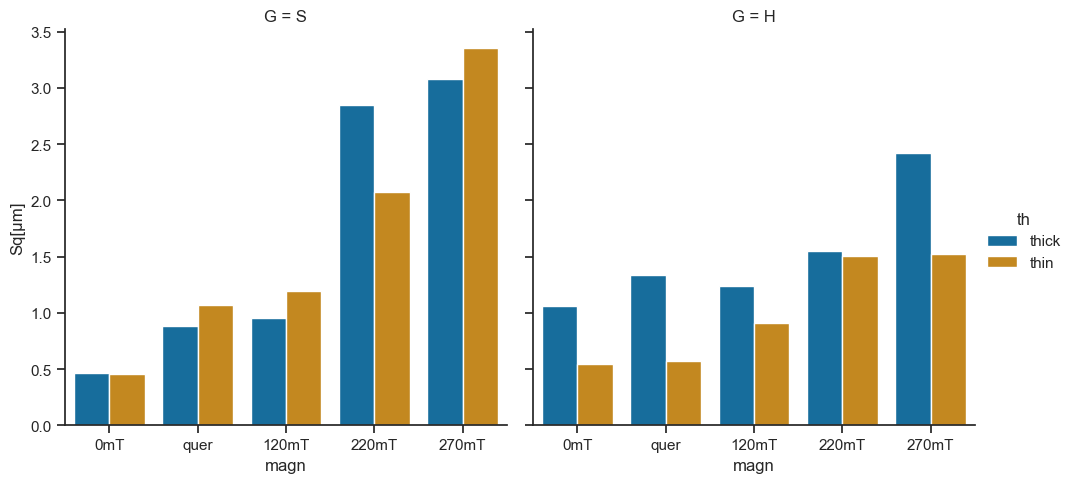

In [ ]:
df = pd.read_csv(source_dir / "compare_magn"/ "roughness.csv")


sns.set_theme(palette="colorblind", style="ticks")
sns.catplot(data=df, x="magn", y="Sq[μm]", col="G",  hue="th", kind="bar" )

### Effects of variables

In [ ]:
fig,axes = plt.subplots(1,3, figsize=(10,3.33), sharey=True, sharex=True)
subplot_labels = ["a)","b)","c)"]
x = np.linspace(0.0005, 0.0015, 250)
norm_x = x / 0.001
for e in [2000, 5000, 10000, 20000, 50000]:
    axes[0].set_title("E")
    fit_y = style_exact(x, 0.072, 1e-3, 39e-3, e, 1e-3)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[0], label=f"{e} Pa")
    axes[0].set_xlabel("r/R")
    axes[0].set_ylabel("Height [µm]")
axes[0].text(0.05, 0.9, subplot_labels[0], transform=axes[0].transAxes)

for ups in np.linspace(0.001,0.1,5):
    axes[1].set_title("Upsilon")
    fit_y = style_exact(x, 0.072, 1e-3, ups, 5000, 0.051e-3)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[1], label=f"{ups*1000:.0f} mN/m")
    axes[1].set_xlabel("r/R")
    axes[1].set_ylabel("Height [µm]")
    axes[1].set_xlim(0.9,1.3)
axes[1].text(0.05, 0.9, subplot_labels[1], transform=axes[1].transAxes)

for h in np.linspace(0.00005,0.0015,5):
    axes[2].set_title("thickness")
    fit_y = style_exact(x, 0.072, 1e-3, 39e-3, 9000, h)*1e6
    sns.lineplot(x=norm_x, y=fit_y, ax=axes[2], label=f"{h*1000:.1f} mm")
    axes[2].set_xlabel("r/R")
    axes[2].set_ylabel("Height [µm]")
axes[2].text(0.05, 0.9, subplot_labels[2], transform=axes[2].transAxes)

plt.tight_layout()
plt.savefig(plot_out_dir / "variable_effects.pdf", bbox_inches="tight")